In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load your dataset
df = pd.read_csv('combined_data.csv')



# Preprocess text
df['content_text'] = df['content_text'].str.lower()  # Convert to lowercase
df['content_text'] = df['content_text'].str.replace(r'@[\w]+', '', regex=True)  # Remove strings starting with @
df['content_text'] = df['content_text'].str.replace(r'[^a-zA-Z\s]', '', regex=True)  # Remove punctuation
df['content_text'] = df['content_text'].str.replace(r'\s+', ' ', regex=True)  # Remove extra whitespaces
df['content_text'] = df['content_text'].str.strip()  # Remove leading/trailing whitespaces
df['content_text'] = df['content_text'].str.replace(r'["\']', '', regex=True)  # Remove punctuation

# Preprocess text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Apply preprocessing
df['processed_texts'] = df['content_text'].apply(preprocess)
prompt_id = 1
# Separate training data based on prompt
train_df = df[df['prompt_id'] != prompt_id]

# Create Dictionary and Corpus
# Remove rare words

dictionary = corpora.Dictionary(train_df['processed_texts'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in train_df['processed_texts']]

# Define number of topics for LDA
num_topics = 8
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42,alpha='auto', passes=100,iterations=400)

# Directories for saving models
model_dir = "lda_models"
dict_dir = "dictionaries"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(dict_dir, exist_ok=True)

# Save LDA model and dictionary
lda_model.save(os.path.join(model_dir, f"lda_model_{prompt_id}.model"))
dictionary.save(os.path.join(dict_dir, f"dictionary_{prompt_id}.dict"))

# Step 6: Evaluate Topics using Coherence Model (c_npmi)
coherence_model = CoherenceModel(model=lda_model, texts=train_df['processed_texts'], dictionary=dictionary, coherence='c_npmi')
topic_coherence = coherence_model.get_coherence_per_topic()
overall_coherence = coherence_model.get_coherence()

# Print topic coherence scores and overall coherence score
print(f"Overall Coherence Score: {overall_coherence}")
for i, coherence in enumerate(topic_coherence):
    print(f"Topic {i}: Coherence Score: {coherence}")

# Print the top words for each topic
for i, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {i}: {topic}")
    
# Optionally, save coherence scores for further analysis
coherence_df = pd.DataFrame({
    'Topic': range(len(topic_coherence)),
    'Coherence Score': topic_coherence,
    'woord_dist': lda_model.print_topics(num_words=10)
})
coherence_df.to_csv(f'topic_coherence_scores_{prompt_id}.csv', index=False)



# Load the saved LDA model and dictionary
lda_model = LdaModel.load(os.path.join(model_dir, f"lda_model_{prompt_id}.model"))
dictionary = corpora.Dictionary.load(os.path.join(dict_dir, f"dictionary_{prompt_id}.dict"))

# Preprocess the test set
test_df = df
test_df['processed_texts'] = test_df['content_text'].apply(preprocess)

# Obtain topic distribution and coherence for new texts
topic_distributions = []

for idx, text in enumerate(test_df['processed_texts']):
    # Convert text to bag-of-words
    new_bow = dictionary.doc2bow(text)

    # Get the topic distribution for the text
    topic_distribution = lda_model.get_document_topics(new_bow)
    topic_distributions.append(topic_distribution)

    # Display topic distribution and coherence score for each document
    print(f"Document {idx + 1}: Topic Distribution: {topic_distribution}")

# Add topic distribution and coherence scores to the DataFrame
test_df['topic_distribution'] = topic_distributions

# find max of topic_distribution
max_topic = []

for topic in topic_distributions:
    max_topic.append(max(topic, key=lambda x: x[1])[1])

test_df['highest_topic'] = max_topic 

# open hand_crafted_v3.csv
data = pd.read_csv('hand_crafted_v3.csv')

# rename essay_id to item_id in test_df
test_df.rename(columns={'essay_id': 'item_id'}, inplace=True)

# Merge the topic distribution and coherence scores on basis of item_id
merged_df = data.merge(test_df[['item_id', 
                                # 'topic_distribution',
                                'highest_topic']], on='item_id')

# save the dataset to a new CSV file
merged_df.to_csv(f'final_{prompt_id}.csv', index=False)




C:\Users\mishr\AppData\Local\Temp\ipykernel_11472\3401674107.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(topic_coherence)), y=topic_coherence, palette="Blues_d")


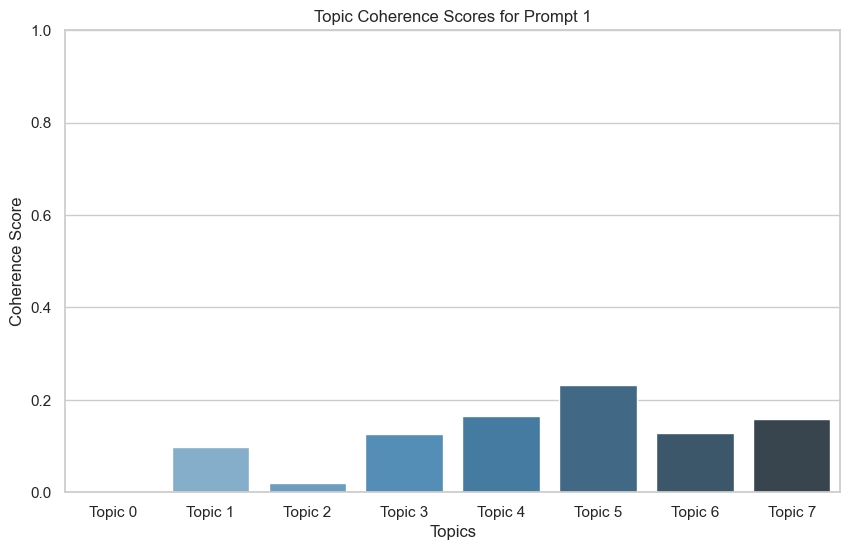

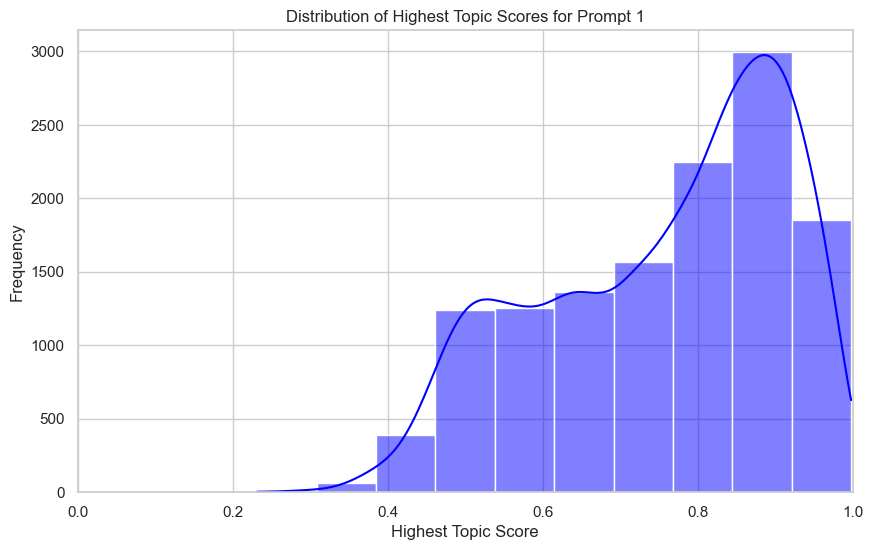

In [8]:
# Import required libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Step 1: Visualize Topic Coherence Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(len(topic_coherence)), y=topic_coherence, palette="Blues_d")
plt.xlabel("Topics")
plt.ylabel("Coherence Score")
plt.title(f"Topic Coherence Scores for Prompt {prompt_id}")
plt.xticks(ticks=np.arange(len(topic_coherence)), labels=[f'Topic {i}' for i in range(len(topic_coherence))])
plt.ylim(0, 1)  # Adjust y-limits for better visualization
plt.show()

# Step 2: Visualize Distribution of Highest Topic Scores
plt.figure(figsize=(10, 6))
sns.histplot(test_df['highest_topic'], bins=10, kde=True, color='blue')
plt.xlabel("Highest Topic Score")
plt.ylabel("Frequency")
plt.title(f"Distribution of Highest Topic Scores for Prompt {prompt_id}")
plt.xlim(0, 1)  # Adjust x-limits if necessary
plt.show()

